### Zadanie 2 
a) PBIL

From wikipedia:
The PBIL algorithm is as follows:

1. A population is generated from the probability vector.
2. The fitness of each member is evaluated and ranked.
3. Update population genotype (probability vector) based on fittest individual.
4. Mutate.
5. Repeat steps 1–4 until some termination (iterations here)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:


class PBIL:
    def __init__(self, cost_function, population_size, chromosome_length, learning_rate, mutation_prob, mutation_shift, iterations):
        self.cost_function = cost_function
        self.population_size = population_size
        self.chromosome_length = chromosome_length
        self.learning_rate = learning_rate
        self.mutation_prob = mutation_prob
        self.mutation_shift = mutation_shift
        self.iterations = iterations
        self.progress = []

        # Poczatkowy wektor prawdopodobienstw
        self.probability_vector = np.ones(chromosome_length) * 0.5

    def generate_population(self):
        population = []
        for _ in range(self.population_size):
            individual = np.random.rand(self.chromosome_length) < self.probability_vector # wypelniamy losowo tablice wartosciami False/True, kazda komorka ma 50% szans na bycie jednym lub drugim
            individual = individual.astype(int) # wyzej ustawilismy wartosci bool, teraz zamieniamy na inty False/True -> 0/1
            population.append(individual)
        return np.array(population)

    def update_probability_vector(self, best_individual):
        # Aktualizowanie wektora prawdopodobieństw w kierunku najlepszego osobnika
        for i in range(self.chromosome_length):
            if best_individual[i] == 1: # Jesli tutaj probability vector miał 1 to nic sie nie zmienia, jak 0 to bardzo zmieniamy (intuicja taka)
                self.probability_vector[i] += self.learning_rate * (1 - self.probability_vector[i])
            else: # == 0
                self.probability_vector[i] -= self.learning_rate * self.probability_vector[i]

    def mutate_probability_vector(self):
        for i in range(self.chromosome_length):
            if np.random.rand() < self.mutation_prob:
                base = (np.random.rand() - 0.5) * 2 # interval [-1, 1]
                mutation = base * self.mutation_shift
                self.probability_vector[i] = np.clip(self.probability_vector[i] + mutation, 0.0, 1.0)

    def run(self):
        best_solution = None
        best_fitness = -1

        for iteration in range(self.iterations):
            # Generowanie populacji
            population = self.generate_population()

            # Obliczanie wartości funkcji kosztu dla każdego osobnika
            fitness_values = np.array([self.cost_function(individual) for individual in population])

            # Znajdujemy najlepszy element
            best_index = np.argmax(fitness_values)
            best_individual = population[best_index]
            best_individual_fitness = fitness_values[best_index]

            # Jesli jego wartosc jest lepsza niz dotychczasowa najlepsza, to jest to nasz nowy najlepszy osobnik
            if best_individual_fitness > best_fitness:
                best_fitness = best_individual_fitness
                best_solution = best_individual

            self.update_probability_vector(best_individual)

            # Mutacja wektora prawdopodobieństw
            self.mutate_probability_vector()
            self.progress.append(best_fitness)

        return best_solution, best_fitness

    def plot_progress(self):
        plt.figure()
        plt.plot(self.progress)
        plt.title(f"PBIL progress on pop_size={self.population_size}, chrom_len={self.chromosome_length}, learning_rate={self.learning_rate}, mutation_prob={self.mutation_prob}, shift={self.mutation_shift}")
        plt.show()

### Cost functions

In [4]:
def one_max_function(p):
    return sum(p)

def deceptive_onemax(individual):
    ones_count = sum(individual)
    
    if ones_count == len(individual):
        return len(individual)
    else:
        return len(individual) - ones_count - 1  # "Deceptive" - zwracamy niższą wartość dla większej liczby jedynek
    
def k_deceptive_onemax(individual, k=4):
    deceptive_value = 0
    # Dzielimy chromosom na bloki o długości K
    for i in range(0, len(individual), k):
        block = individual[i:i+k]
        ones_count = sum(block)
        
        # Zasada: dla pełnych jedynek dajemy maksymalną wartość,
        # ale dla częściowych jedynek wynik jest gorszy im więcej jedynek (oprócz pełnych)
        if ones_count == k:
            deceptive_value += k  # Optimum dla pełnego bloku jedynek
        else:
            deceptive_value += (k - ones_count - 1)  # Preferujemy więcej zer, aż do pełnych jedynek
    
    return deceptive_value

Testing different sizes of problem

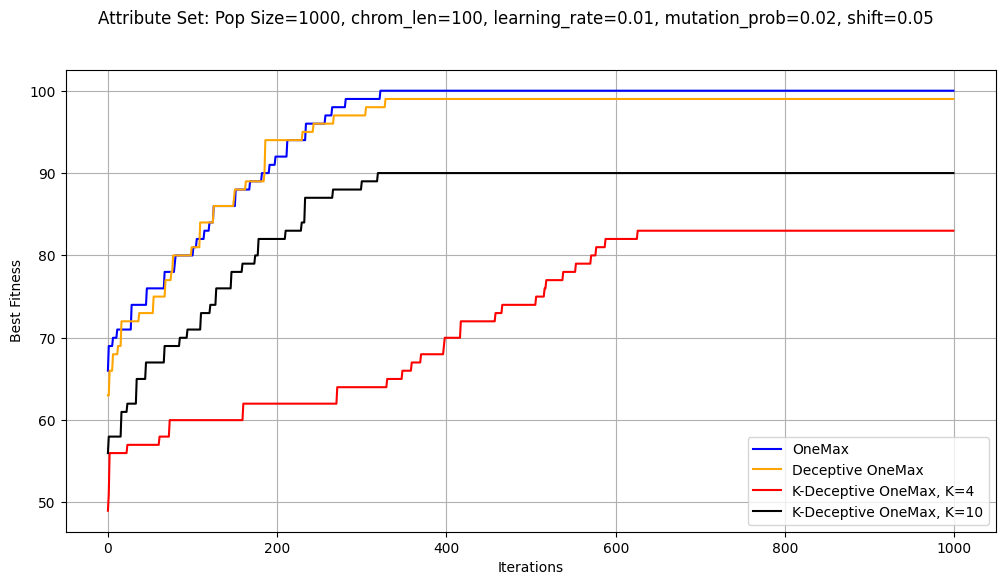

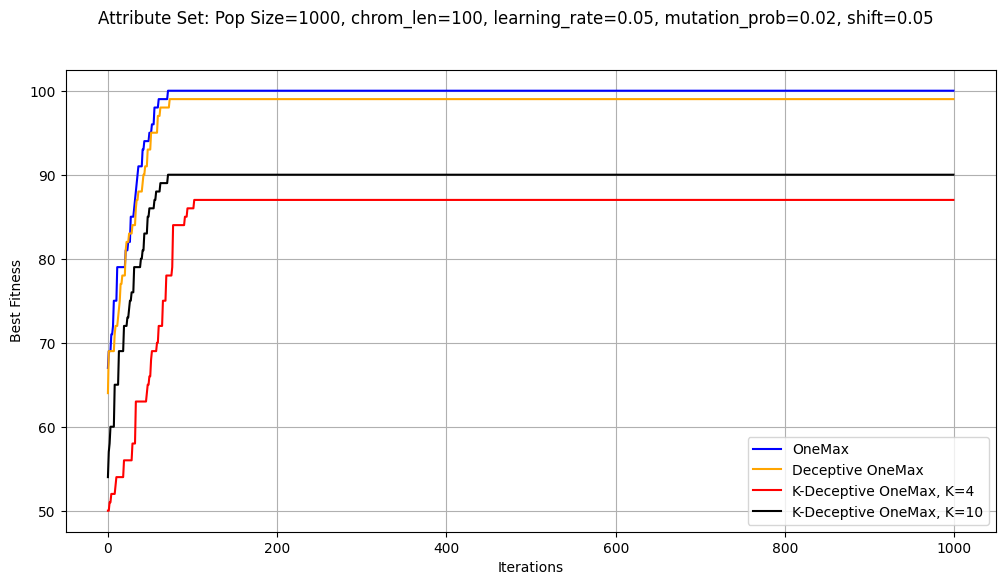

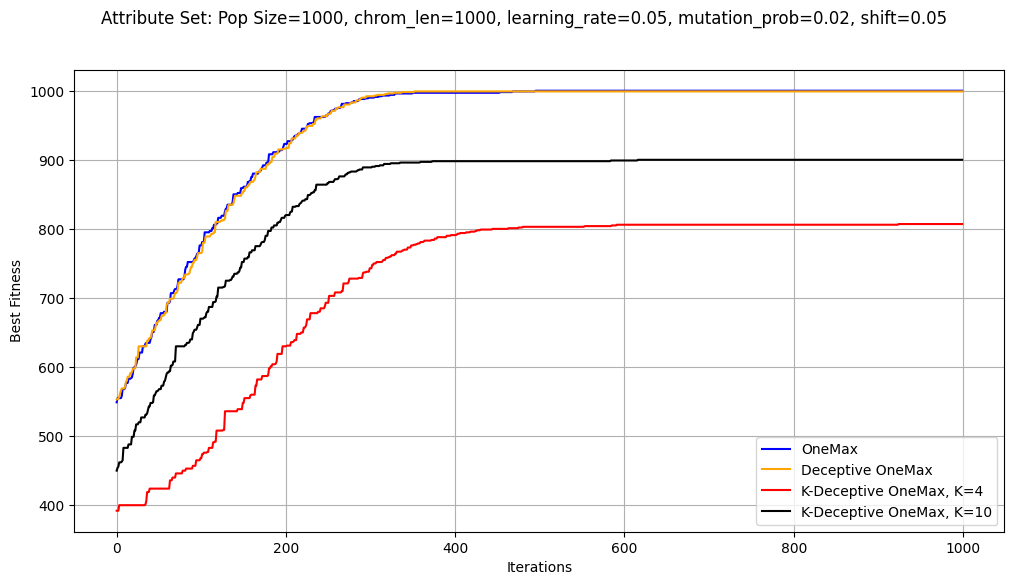

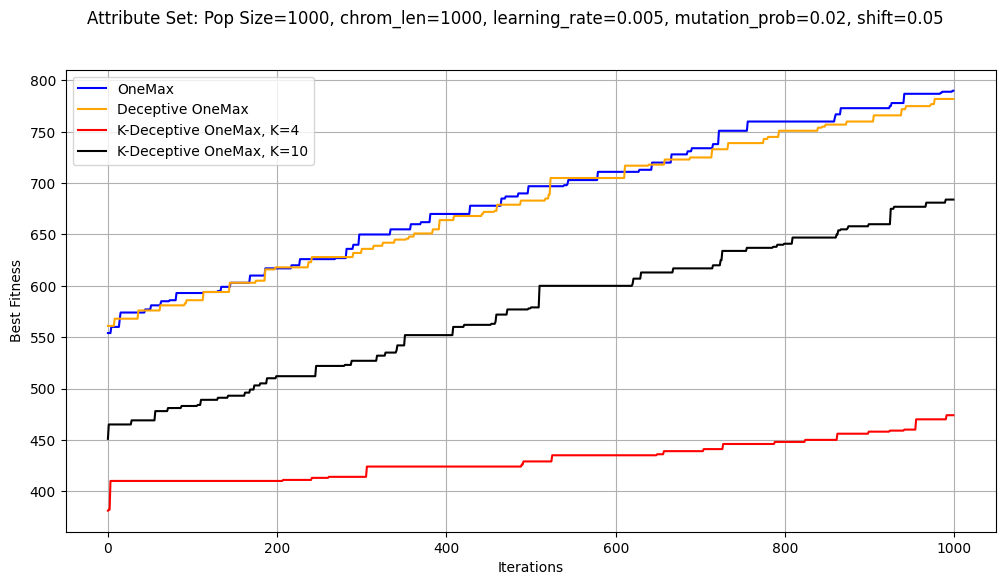

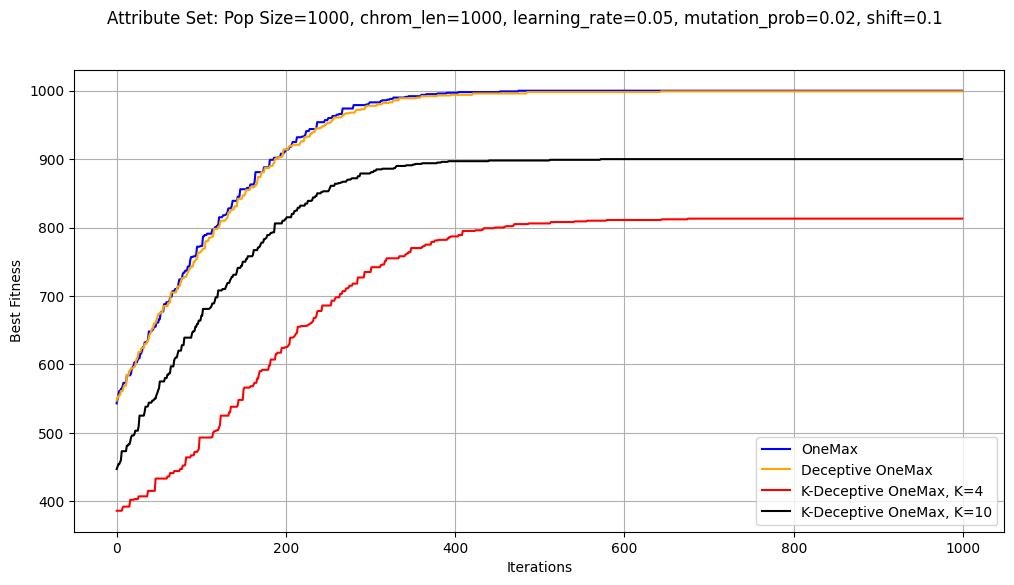

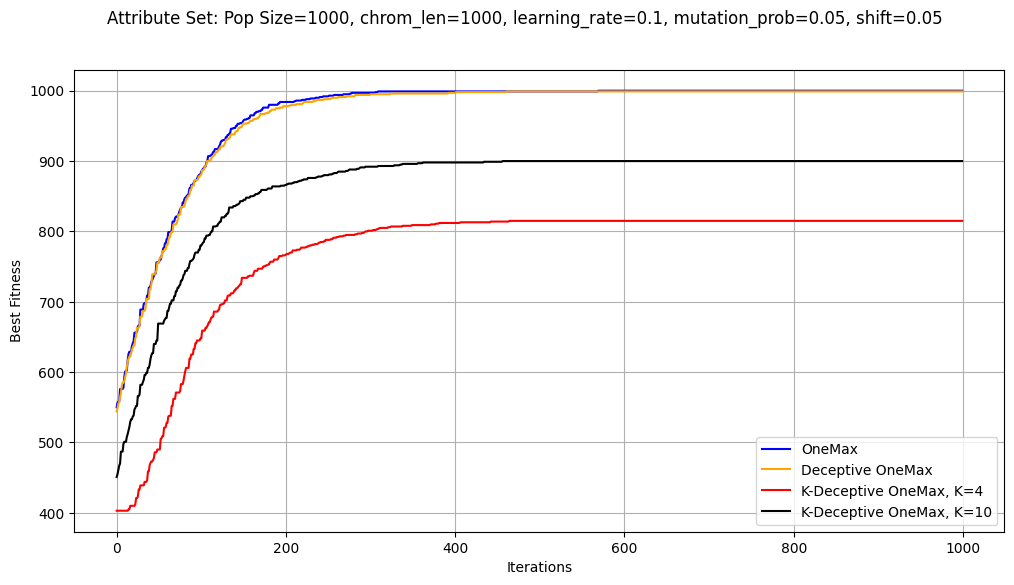

In [5]:
iterations = 1000
attribute_sets = ( # Population size, length of chromosome, learning rate, mutation probability, mutation shift
    (1000, 100, 0.01, 0.02, 0.05),
    (1000, 100, 0.05, 0.02, 0.05),
    (1000, 1000, 0.05, 0.02, 0.05),
    (1000, 1000, 0.005, 0.02, 0.05),
    (1000, 1000, 0.05, 0.02, 0.1),
    (1000, 1000, 0.1, 0.05, 0.05),
)

for attribute_set in attribute_sets:
    plt.figure(figsize=(12, 6))
    pbil_one_max = PBIL(
        one_max_function,
        attribute_set[0],
        attribute_set[1],
        attribute_set[2],
        attribute_set[3],
        attribute_set[4],
        iterations
    )
    best_solutions_one_max = pbil_one_max.run()
    pbil_deceptive_one_max = PBIL(
        deceptive_onemax,
        attribute_set[0],
        attribute_set[1],
        attribute_set[2],
        attribute_set[3],
        attribute_set[4],
        iterations
    )
    best_solutions_deceptive_one_max = pbil_deceptive_one_max.run()
    pbil_4deceptive_one_max = PBIL(
        lambda individual: k_deceptive_onemax(individual, 4),
        attribute_set[0],
        attribute_set[1],
        attribute_set[2],
        attribute_set[3],
        attribute_set[4],
        iterations
    )
    best_solutions_kdeceptive_one_max = pbil_4deceptive_one_max.run()
    pbil_10deceptive_one_max = PBIL(
        lambda individual: k_deceptive_onemax(individual, 10),
        attribute_set[0],
        attribute_set[1],
        attribute_set[2],
        attribute_set[3],
        attribute_set[4],
        iterations
    )
    best_solutions_kdeceptive_one_max = pbil_10deceptive_one_max.run()
    plt.plot(pbil_one_max.progress, label='OneMax', color='blue')
    plt.plot(pbil_deceptive_one_max.progress, label='Deceptive OneMax', color='orange')
    plt.plot(pbil_4deceptive_one_max.progress, label='K-Deceptive OneMax, K=4', color='red')
    plt.plot(pbil_10deceptive_one_max.progress, label='K-Deceptive OneMax, K=10', color='black')
    plt.suptitle(f'Attribute Set: Pop Size={attribute_set[0]}, chrom_len={attribute_set[1]}, learning_rate={attribute_set[2]}, mutation_prob={attribute_set[3]}, shift={attribute_set[4]}')
    plt.xlabel('Iterations')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()
    

Testowałem różne kombinacje wartości, starając się w danym uruchomieniu zmieniać jedną z nich by zobaczyć wpływ. Te najciekawsze albo jakkolwiek wyróżniające się tutaj zebrałem i zostawiłem. K-Deceptive OneMax dla K=4 wydaje się być zbyt trudny dla PBIL. Ogólnie wszystkie problemy wydają się w pewnym momencie stopować w miejscu, mimo że nie są w optimum. Próbowałem zwiększać parametry mutacji, prawdopodobieństwo i siłę mutacji ale wyniki były nawet gorsze, bo nie polepszały K-Deceptive, a pogarszały OneMax'a i zwykłego Deceptive OneMax'a.